# Samo organizujuće mape - SOM

Smoorganizujuce mape predstavljaju specijalnu vrstu neuronskih mreza u kojima se neuroni organizuju u 1D, 2D ili 3D resetku u kojoj svaki neuron ima informaciju o susednim neuronima. Na slici 1. prikazan je jedan primer 2D SOM rešetke sa 10x10 neurona.

![alt text](images/som-10x10.svg "Title")

Slika 1. Primer 2D SOM sa 10x10 neurona

Neuroni pored informacija o susednim neuronima imaju vektor sinapsi (w) preko kojih su povezani sa 'ulazom'.

Obucavanje SOM:
```
1) sinapse neurona se inicijalno postave na slučajne vrednosti
2) iterativno kroz epohe prolaziti kroz slučajno izabrane primere za obucavanje i raditi sledeće:
    2.1) pronaći pobednički neuron, neuron kod kojeg je rastojanje između sinapsi i primera minimalno
    2.2) korigovari sinapse pobedničkog neurona tako da "liče" na primer
```

![alt text](images/som-10x10-win.svg "Title")

Slika 2. Pobednički neuron na koordinatama 4,4

```
    2.3) korigovati susede pobedničkog neurona tako da postanu sličniji pobedničkom neuronu
```

![alt text](images/som-10x10-2.svg "Title")

Slika 3. Korekcija suseda pobedničkog neurona

```
    2.4) korekciju susednih neurona smanjivati proporcionalno rastojanju
```
![alt text](images/som-10x10-31.svg "Title")

Slika 4. Smanjivanje uticaja pobedničkog neurona u vremenu


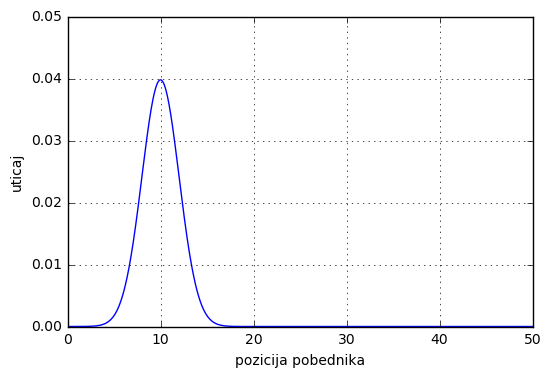

In [177]:
import numpy as np


def gauss(x, x0, sigma):
    r = (x - x0)**2
    A = 1/(2.0*np.pi*sigma**2)
    y = A*np.exp(-r/(2.0*sigma**2))
    return y

x = np.arange(0, 50, 0.01)
y = gauss(x, 10, 2)
import math
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x, y, c='b')
plt.ylim((0, 0.05))
plt.xlabel('pozicija pobednika')
plt.ylabel('uticaj')
plt.grid(True)


## Implementacija

In [178]:
class Neuron:
    def __init__(self, x, y, length, min_w, max_w):
        self.x = x
        self.y = y
        self.length = length
        self.w = [np.random.uniform(-1,10) for i in range(self.length)]
        self.lr = 0.1
        self.decay = 0.00001
        
    def distance(self, example):
        #return np.sqrt(np.sum((self.w-example)**2))        
        return np.sum((self.w-example)**2)        
        
    def gauss(self, win, it):
        r2 = (win.x-self.x)**2+(win.y-self.y)**2
        sigma = 1
        A = 1/(2.0*np.pi*sigma**2)
        g = A*np.exp(-r2/(2.0*sigma**2))
        return g
    
    def learningRate(self, it):
        self.lr -= self.decay
        self.lr = max([0.001, self.lr])
        return self.lr
                       
    def update(self, example, win, it):      
        lr = self.learningRate(it)
        gg = self.gauss(win, it)        
        
        dw = np.zeros(2)
        dw = lr*gg*(example-win.w)
        self.w += dw
        return np.sum(dw**2)


In [179]:
class SOM:
    def __init__(self, dim, length, min_w, max_w):
        self.dim = dim
        self.length = length #velicina vektora sinapsi zavisi od problema
        self.neurons = []
        for i in range(self.dim):
            el = []
            for j in range(self.dim):
                neuron = Neuron(i, j, self.length, min_w, max_w)
                el.append(neuron)
            self.neurons.append(el)        
    
    def model(self):
        ret = []
        for i in range(self.dim):
            for j in range(self.dim):
                neuron = self.neurons[i][j]
                ret.append(np.array(neuron.w))
        return np.array(ret)
            
    def winner(self, example):
        retVal = self.neurons[0][0]
        _min = retVal.distance(example)
        for i in range(self.dim):
            for j in range(self.dim):
                neuron = self.neurons[i][j]
                d = neuron.distance(example)
                if d<_min:
                    _min = d
                    retVal = neuron
        return retVal
    
    def update(self, example, it):
        error = 0
        winner = self.winner(example)
        for i in range(self.dim):
            for j in range(self.dim):
                neuron = self.neurons[i][j]
                error += neuron.update(example, winner, it)
        return error/float(self.dim**2)
                        
    
    def fit(self, examples):
        ret = []
        maxerr = 0.00001
        blok = 100
        for it in range(1000):
            err = 0
            n = 10
            for i in range(n):
                el = random.choice(examples)
                err += self.update(el, it)
            err = err/float(n)
            ret.append(self.model())
        return np.array(ret)

    def debug(self):
        for i in range(self.dim):
            for j in range(self.dim):
                neuron = self.neurons[i][j]
                print i, j, neuron.w
        

## Primer korišćenja 1

Generisaćemo 4 grupe 2D tačaka i pokušaćemo da primenom SOM 2x2 uradimo grupisanje neobeleženih primera.

In [284]:
import random

_examples = [[0,0], [15,15], [0,10], [10,0]]
examples = []

for el in _examples:
    for r in range(40):
        da = random.uniform(-2, 2)
        db = random.uniform(-2, 2)
        examples.append([el[0]+da, el[1]+db])

examples = np.array(examples)

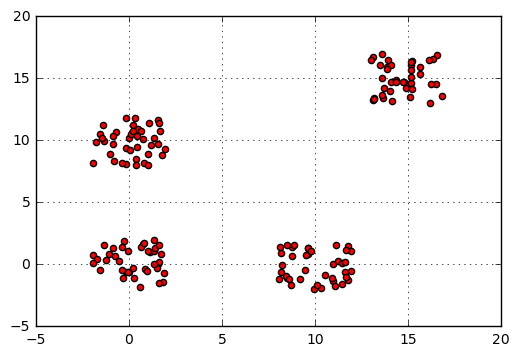

In [285]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(examples[:,0], examples[:,1], c='r')

plt.grid(True)


In [286]:
som = SOM(2, 2, -1, 10)

In [287]:
tr = som.fit(examples)

In [288]:
som.debug()

print tr.shape

0 0 [ 9.85779427  0.23102614]
0 1 [ 14.88345034  14.64485371]
1 0 [ 0.42518895 -0.01081789]
1 1 [ -0.03284175  10.33038251]
(1000, 4, 2)


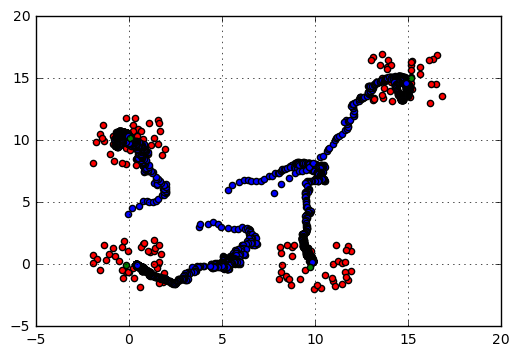

In [289]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(examples[:,0], examples[:,1], c='r')
plt.scatter(tr[:,0,0], tr[:,0,1], c='b')
plt.scatter(tr[:,1,0], tr[:,1,1], c='b')
plt.scatter(tr[:,2,0], tr[:,2,1], c='b')
plt.scatter(tr[:,3,0], tr[:,3,1], c='b')
plt.scatter(model[:,0], model[:,1], c='g')

plt.grid(True)

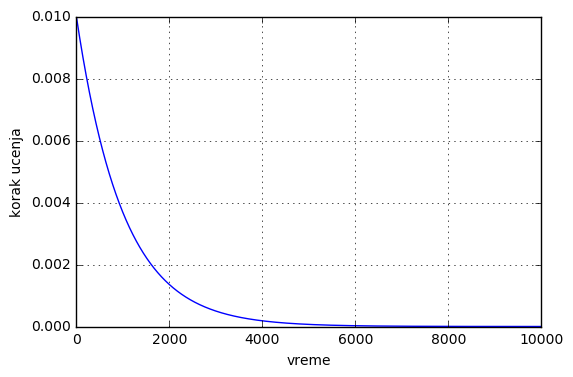

In [290]:
x = np.arange(0, 10000)
y = 0.01*np.exp(-x/1000.)
import math
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x, y, c='b')
plt.xlabel('vreme')
plt.ylabel('korak ucenja')
plt.grid(True)

## Primer koriscenja 2

Analiziraćemo boje na slici i pokušaćemo da ih u 9 grupa najsličnijih i najdominantnijih

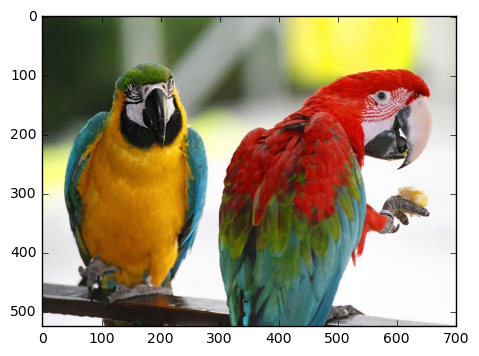

In [291]:
from skimage.io import imread
from scipy import ndimage

img = imread('images/papagaji.jpg')
plt.imshow(img)  # imshow je funkcija za prikaz slike (u formatu Numpy array-a)

In [292]:
# boja pixela na koordinatama 100, 100
print img[100, 100, :]

# dimenzije slike
print img.shape

[52 65 39]
(525, 700, 3)


In [293]:
som = SOM(5, 3, 0, 255)

In [294]:
# generisati primere za obucavanje
examples = []

img2 = np.zeros((100, 100, 3)).astype(int)
img21 = np.zeros((img.shape[0], img.shape[1], 3)).astype(int)

for x in range(100):
    for y in range(100):
        i = random.randint(0, img.shape[0]-1)
        j = random.randint(9, img.shape[1]-1)
        pixel = img[i, j, :]
        img2[x,y,:] = 256-pixel
        img21[i,j,:] = 256-pixel
        examples.append(pixel)

examples = np.array(examples)

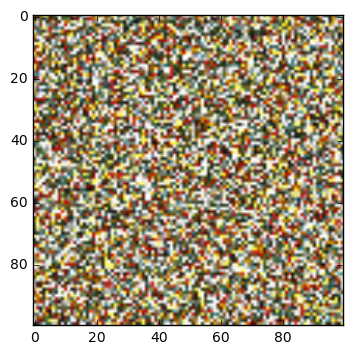

In [295]:
plt.imshow(img2)

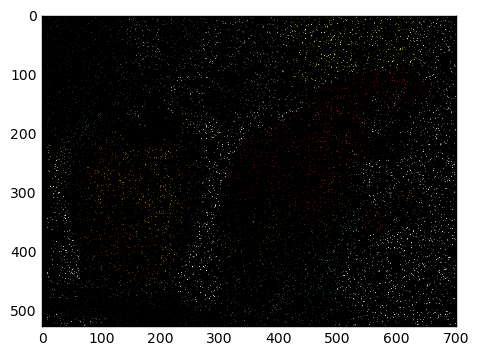

In [296]:
plt.imshow(img21)

In [297]:
tr = som.fit(examples)

In [298]:
som.debug()

0 0 [ 31.84031445  -4.54401181  12.57259977]
0 1 [ 67.6466362   -1.22567439   3.79222204]
0 2 [ 96.01149144  45.27628692   6.74620349]
0 3 [ 85.15136295  96.94135224  63.06553429]
0 4 [ 50.55058769  70.18769296  49.23396037]
1 0 [ 62.91577958  -7.4785673   20.58770007]
1 1 [ 148.94201689   31.33128377   -0.94563898]
1 2 [ 214.33016924  139.35250353   44.46008964]
1 3 [ 189.99421736  186.00142045  163.39700608]
1 4 [ 108.43600051  121.52568056  127.35603521]
2 0 [ 68.14498851   7.41298043  24.89468705]
2 1 [ 168.17425495   83.44086597   20.39631582]
2 2 [ 255.08057478  222.09428222   87.57037302]
2 3 [ 244.78948134  252.14827739  242.90036249]
2 4 [ 128.17366215  149.89871032  182.76553453]
3 0 [ 38.45223178   8.74047619  18.09185292]
3 1 [ 82.15333592  63.6600069   23.46348748]
3 2 [ 125.56534586  144.09449482   59.85319779]
3 3 [ 134.52419002  146.03759936  137.08995546]
3 4 [  62.27408454   97.20626903  102.262272  ]
4 0 [ 11.21206993   9.40520199   5.00191841]
4 1 [ 19.47185842  21.

In [299]:
import cv2
   
R = 30   
# Create a gray image
img3 = 128+np.zeros(((som.dim-1)*R+2*R, (som.dim-1)*R+2*R,3), np.uint8)

In [300]:
for i in range(som.dim):
    for j in range(som.dim):
        neuron = som.neurons[i][j]        
        cv2.circle(img3, (R+i*R,R+j*R), R/2-5, neuron.w.astype(int), -1)


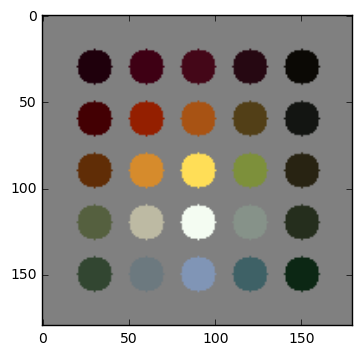

In [301]:
plt.imshow(img3)

# Primeniti filter na orginalnu sliku

0
50
100
150
200
250
300
350
400
450
500


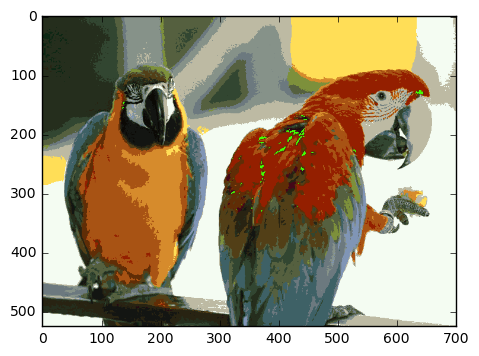

In [302]:
img4 = np.zeros((img.shape[0], img.shape[1], 3))

for x in range(img.shape[0]):
    if(x%50==0):
        print x
    for y in range(img.shape[1]):
        pixel = img[x, y, :]
        winner = som.winner(pixel)
        ppixel = winner.w.astype(int)
        img4[x,y,:] = 256-ppixel

plt.imshow(img4)        

# Manja SOM rešetka


In [303]:
som = SOM(3, 3, 0, 255)
tr = som.fit(examples)

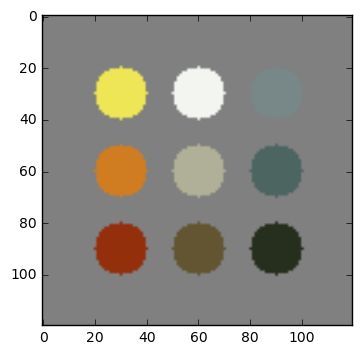

In [304]:
img3 = 128+np.zeros(((som.dim-1)*R+2*R, (som.dim-1)*R+2*R,3), np.uint8)
for i in range(som.dim):
    for j in range(som.dim):
        neuron = som.neurons[i][j]        
        cv2.circle(img3, (R+i*R,R+j*R), R/2-5, neuron.w.astype(int), -1)
plt.imshow(img3)

In [305]:
som.debug()

0 0 [ 239.53825916  230.6547924    85.67886841]
0 1 [ 208.45942938  125.53325628   33.30739033]
0 2 [ 147.81566718   47.3962421    10.21903494]
1 0 [ 243.90060782  246.61135779  240.32187764]
1 1 [ 175.64277891  176.47400295  151.94747685]
1 2 [ 99.14765009  85.80671057  50.09627064]
2 0 [ 120.47576405  135.90260786  136.93803778]
2 1 [  76.65173685  101.61696114   97.01799414]
2 2 [ 38.4932083   47.30596006  29.41598014]


0
50
100
150
200
250
300
350
400
450
500


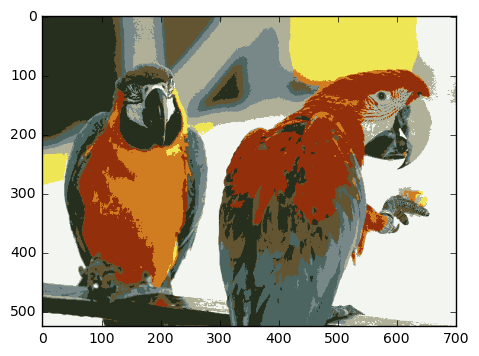

In [306]:
img4 = np.zeros((img.shape[0], img.shape[1], 3))

for x in range(img.shape[0]):
    if(x%50==0):
        print x
    for y in range(img.shape[1]):
        pixel = img[x, y, :]
        winner = som.winner(pixel)
        ppixel = winner.w.astype(int)
        img4[x,y,:] = 256-ppixel

plt.imshow(img4)        

## Jako velika rešetka

In [307]:
som = SOM(10, 3, 0, 255)
tr = som.fit(examples)

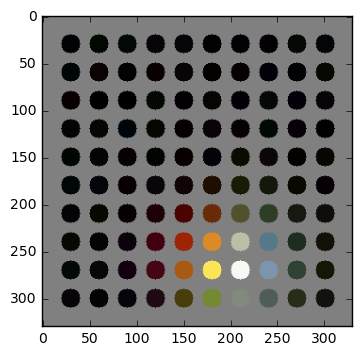

In [308]:
img3 = 128+np.zeros(((som.dim-1)*R+2*R, (som.dim-1)*R+2*R,3), np.uint8)
for i in range(som.dim):
    for j in range(som.dim):
        neuron = som.neurons[i][j]        
        cv2.circle(img3, (R+i*R,R+j*R), R/2-5, neuron.w.astype(int), -1)
plt.imshow(img3)